# MCNN - PyTorch Implementation
**Author**: Johannes S. Fischer

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchmetrics

from model import MCNN
from transforms import Identity, MovingAvg, Downsample
from dataloader import ECG5000

## Data
Using the `ECG5000` dataset for testing. Information can be found [here](https://timeseriesclassification.com/description.php?Dataset=ECG5000).

Train: (500, 141)
Test: (4500, 141)


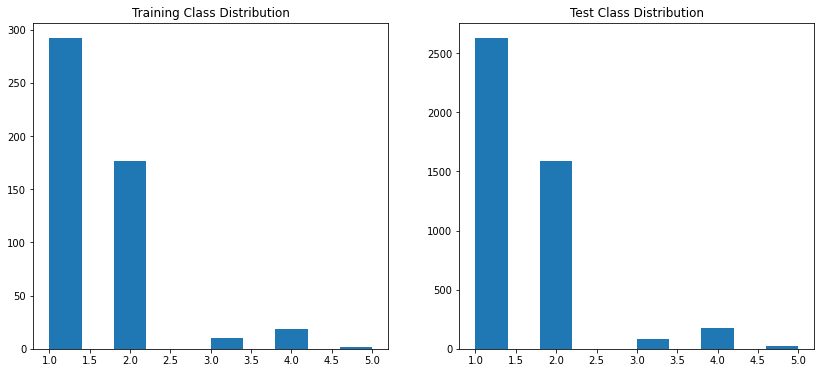

In [8]:
train_data = np.loadtxt('./data/ECG5000_TRAIN.txt')
test_data = np.loadtxt('./data/ECG5000_TEST.txt')

print("Train:", train_data.shape)
print("Test:", test_data.shape)

Y_train = train_data[:, 0]
Y_test = test_data[:, 0]

n_classes = len(np.unique(Y_train))

plt.subplots(1,2,figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(Y_train)
plt.title('Training Class Distribution')
plt.subplot(1,2,2)
plt.hist(Y_test)
plt.title('Test Class Distribution')
plt.show()

Reshape for `PyTorch` to have $(n, c, l)$ with $n$ being the number of samples, $c$ being the number of channels, which is one for this univariate dataset, and $l$ being the length, using the `ECG5000` dataloader.

In [4]:
training_data = ECG5000(train_data)
test_data = ECG5000(test_data)

train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

## Model
Creating a single model without applying grid search.

In [15]:
transformations = {
    'identity': {
        'class': Identity,
        'params': []
    },
    'movingAvg': {
        'class': MovingAvg,
        'params': [3,4,5]       # window sizes
    },
    'downsample': {
        'class': Downsample,
        'params': [2,3]       # sampling rates
    }
}

ts_length = 140
ts_shape = (1, ts_length)
pool_factor = 4
kernel_size = int(ts_length*0.05)

model = MCNN(ts_shape, n_classes, pool_factor, kernel_size, transformations)

optim = torch.optim.Adam(model.parameters())

print(model)

MCNN(
  (branches): ModuleList(
    (0): Sequential(
      (identity_transform): Identity()
      (identity_conv): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
      (identity_activation): ReLU()
      (identity_pool): MaxPool1d(kernel_size=35, stride=35, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (movingAvg_3_transform): MovingAvg()
      (movingAvg_3_conv): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
      (movingAvg_3_activation): ReLU()
      (movingAvg_3_pool): MaxPool1d(kernel_size=34, stride=34, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (movingAvg_4_transform): MovingAvg()
      (movingAvg_4_conv): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
      (movingAvg_4_activation): ReLU()
      (movingAvg_4_pool): MaxPool1d(kernel_size=34, stride=34, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (movingAvg_5_transform): MovingAvg()
      (movingAvg_5_conv

## Training

In [16]:
EPOCHS = 4

results = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

for epoch in range(EPOCHS):

    # training
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for x, y in train_loader:
        yhat = model.forward(x)

        loss = torch.nn.CrossEntropyLoss()(yhat, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_losses.append(loss.item())
        acc = torchmetrics.functional.accuracy(yhat, y.int())
        epoch_accuracies.append(acc)

    epoch_loss = np.mean(epoch_losses)
    epoch_acc = np.mean(epoch_accuracies)

    # validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []
    with torch.no_grad():
        for x, y in test_loader:
            yhat = model.forward(x)
            loss = torch.nn.CrossEntropyLoss()(yhat, y)
            epoch_val_losses.append(loss.item())
            acc = torchmetrics.functional.accuracy(yhat, y.int())
            epoch_val_accuracies.append(acc)

    epoch_val_loss = np.mean(epoch_val_losses)
    epoch_val_acc = np.mean(epoch_val_accuracies)

    # populate results
    results['loss'].append( epoch_loss )
    results['val_loss'].append( epoch_val_loss )
    results['acc'].append( epoch_acc )
    results['val_acc'].append( epoch_val_acc )

    #if (epoch+1) % 5 == 0 or epoch+1 == EPOCHS:
    print("Epoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain Accuracy: {:.2f}%\tTest Accuracy: {:.2f}%".format(
            epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_acc*100, epoch_val_acc*100) )

Epoch 1/4	Train Loss: 1.0954	Test Loss: 1.0026	Train Accuracy: 92.87%	Test Accuracy: 96.08%
Epoch 2/4	Train Loss: 0.9927	Test Loss: 1.0149	Train Accuracy: 96.52%	Test Accuracy: 95.60%
Epoch 3/4	Train Loss: 1.0039	Test Loss: 0.9975	Train Accuracy: 96.00%	Test Accuracy: 96.29%
Epoch 4/4	Train Loss: 0.9822	Test Loss: 0.9937	Train Accuracy: 96.91%	Test Accuracy: 96.43%


## Results

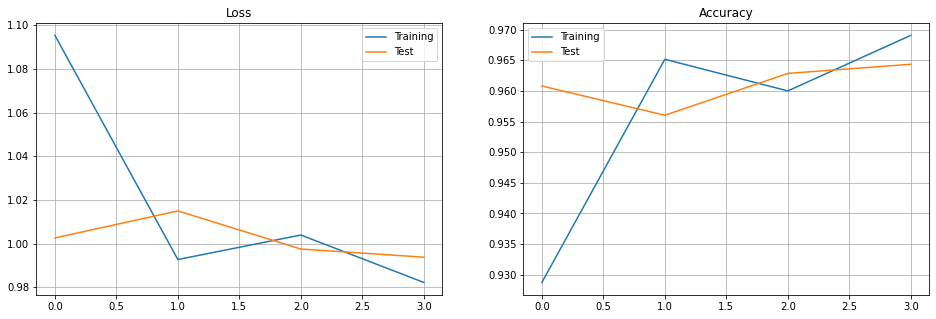

In [20]:
plt.subplots(1, 2, figsize=(16, 5))

plt.subplot(121)
plt.plot(results['loss'], label='Training')
plt.plot(results['val_loss'], label='Test')
plt.grid('on')
plt.legend()
plt.title('Loss')

plt.subplot(122)
plt.plot(results['acc'], label='Training')
plt.plot(results['val_acc'], label='Test')
plt.grid('on')
plt.legend()
plt.title('Accuracy')

plt.show()

---